# Ramsey examples using Evolver

### Summary

This script contains the same examples as the previously posted "SQ Ramsey Pulsehandler Tutorial" but now using the _new_ base scripts.

In the Ramsey sequence, a microwave $\pi/2$-pulse is first applied to drive the electronic spin state. Then, the state undergoes free evolution for some amount of time $\tau$, before a second $\pi/2$-pulse is applied. The final state of the system is then measured after the second pulse.

By repeating the Ramsey experiment with different values of the free evolution time $\tau$, the spin population time series $S(\tau)$ can be measured. For a two-level system with resonance frequency $\omega_0$ and a drive field at frequency $\omega$, the signal $S(\tau)$ oscillates at a frequency equal to the detuning $\Delta$ of the applied microwave drive,

$$ \Delta = \omega-\omega_0 $$

Changes in the effective detuning $\Delta $ can result from a target magnetic field (to be sensed). Since the measurement is sensitive to changes in the detuning, the Ramsey method can be used for magnetometry of DC to low-frequency signals.

### Import packages

In [26]:
from qutip import *
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import scipy.signal as scs
from multiprocess import Pool
import time
from scipy.optimize import curve_fit
import sys


In [31]:
# Add path to personal directory to searchable directory list
dirpath_pers = "dir/to/path"

if dirpath_pers not in sys.path:
    sys.path.insert(0, dirpath_pers)

In [32]:
from tempo.hamiltonian import Hamiltonian
from tempo.pulse_recipe import Pulse_recipe
from tempo.evolver import Evolver
from tempo.pulse_sequence import Pulse_sequence
from tempo.pulse import Pulse

from examples.qsys import Qsys
from examples.hamfuncs import *

### Define NV system

The Qsys constructor takes a tuple of the dimensions of each particle's Hilbert space. In this case the tuple has two entries because we have two particles, with the electron having spin-1 and the nucleus having spin-1/2. 

In [33]:
# initialize the NV system: (3, 2) for the dimensions of the electron's and nucleus' Hilbert spaces
# creates a coupled system of the two spins
qs = Qsys((3,2))

### Define system's initial state for solver

For this simulation, we will use ms = 0, mi = +1/2.

In [34]:
state_init = tensor(basis(3,1), basis(2, 0)) # ms = 0 (electron), mi = +1/2 state (nucleus)
state_init

Quantum object: dims = [[3, 2], [1, 1]], shape = (6, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

### Applied B-field (static)

In [35]:
#
# Applied magnetic field
#
Bx = 0; By = 0; Bz = 300 # B field components (G)
B0_init = np.array([Bx, By, Bz]) # B field vector (G)

# If desired, rotate magnetic field around y-axis, by angle theta
theta = 0 #degrees
theta *= np.pi/180
Ry = np.array([[np.cos(theta), 0, np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]]) # rotation opr
B0 = np.dot(Ry, B0_init) 
print(B0)

[  0.   0. 300.]


### Set up static Hamiltonian

Set up a static Hamiltonian with hyperfine interaction for the system (from QuTiP tutorial): 

$$
\frac{\hat{H}}{h} =  \underbrace{D \hat{S}_z^2}_\text{Zero-field splitting} + \underbrace{\gamma_e \vec{B}\cdot \vec{S}}_\text{Electron Zeeman interaction} + \underbrace{\gamma_n \vec{B}\cdot \vec{I}}_\text{Nuclear Zeeman interaction} + \underbrace{\vec{S} \cdot \overline{A} \cdot \vec{I}}_\text{Hyperfine interaction} + \underbrace{\Big(Q \hat{I}_z^2\Big)}_\text{Quadrupole Splitting (N14)} + \underbrace{\cos{(\omega t)} \cdot \sqrt{2}\Omega \hat{S}_x}_\text{Microwave drive}
$$

Above, the first 5 terms are static and the last is the time-dependent term or the "pulse." $\vec{S}$ and $\vec{I}$ contain the spin operators for the electron and nuclear spin respectively. 

$\vec{B}$ is the magnetic field vector relative to an NV$^-$ axis oriented in the z-direction.

$$\vec{S} = \begin{pmatrix} \hat{S}_x \\ \hat{S}_y \\\hat{S}_z\end{pmatrix}, \vec{I} = \begin{pmatrix} \hat{I}_x \\ \hat{I}_y \\\hat{I}_z\end{pmatrix}, \vec{B} = \begin{pmatrix} B_x \\ B_y \\ B_z\end{pmatrix}, \overline{A} = \begin{bmatrix} A_\perp & 0 & 0\\ 0 & A_\perp & 0 \\ 0 & 0 & A_{||}\end{bmatrix}$$

In the Rabi tutorial "Evolver_Rabiexample" we showed how to use the Hamiltonian class to define the static terms. Here, we are doing the same but the methods are wrapped in the file hamfuncs.py to take away some clutter. 

In [36]:
# create Hamiltonian objects to store these terms
HZFS = ZFS(qs)
HZeeNV = Zeeman(qs, B0)
HZeeNuc = Zeeman(qs, B0, nuc = True)
HHF = Hyperfine(qs)

In [37]:
# get the total static Hamiltonian operator
Hstat = HZFS.H + HZeeNV.H + HZeeNuc.H + HHF.H
Hstat

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 2.33172517e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.33134081e+04  2.58093975e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.58093975e+00  4.06773417e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.06773417e-01
   2.58093975e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.58093975e+00
   1.27490456e+04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.27512620e+04]]

### Determine frequency of excitation

The function ret_transition_frq(i0, if, s0, sf) calculates the difference between energy eigenvalues $\omega_0 = E_\text{sf,if}-E_\text{s0,i0}$. The transition we are looking at is ms = 0 to ms = +1.

$E_\text{i,j}$ corresponds to energy eigenvalue of electronic basis index $i$ (0, 1 or 2) and nuclear basis index $j$ (0 or 1 for 15N. 0,1 or 2 for 14N). 

In [38]:
 def ret_transition_frq(Ham, idx_mi0, idx_mif, idx_ms0=1, idx_msf=0):
    #
    # Return frequency difference (MHz) between two eigenstates 
    #

    eigenvals, eigenstates = Ham.eigenstates()
    state0 = tensor(basis(qs.dimensions[0], idx_ms0), basis(qs.dimensions[1], idx_mi0))
    statef = tensor(basis(qs.dimensions[0], idx_msf), basis(qs.dimensions[1], idx_mif))

    idx_e0 = np.argmax([np.sum(np.abs(eigenstates[i].full())*state0.full()) for i in np.arange(len(eigenvals))])
    idx_ef = np.argmax([np.sum(np.abs(eigenstates[i].full())*statef.full()) for i in np.arange(len(eigenvals))])

    frq_trans = (eigenvals[idx_ef] - eigenvals[idx_e0])/2/np.pi 
    return frq_trans #MHz

In [39]:
frq_trans = ret_transition_frq(Hstat, 0, 0, idx_ms0=1, idx_msf=0) # ms=0 <=> ms=+1 transition

print('frq_trans', frq_trans, ' MHz')

frq_trans 3710.991165214304  MHz


In [40]:
frq_trans

3710.991165214304

### Drive magnetic field amplitude

The static Hamiltonian acquires a time-dependent component during the microwave drive:

\begin{equation}
\frac{\hat{H}(t)}{\hbar} = 2\pi\cdot \underbrace{\cos{(\omega t)}}_\text{time-dependent coefficient} \cdot \sqrt{2}\Omega \hat{S}_x
\end{equation}

where $ \Omega $ is the Rabi frequency and $ \omega $ is the driving frequency. $\Omega $ describes the strength of the driving field via a general formula $ \Omega = -\gamma B $. $ 
S_x $ is the electron spin operator 

\begin{equation}
\hat{S}_x = \frac{1}{\sqrt{2}} \cdot \left[\begin{matrix}0 & 1 & 0\\1 & 0 & 1\\0 & 1 & 0\end{matrix}\right] \otimes \mathbb{1}
\end{equation}

Apply a microwave drive to system during the two pulses.

In [41]:
# Number corresponds approximately to rabi freq in MHz (exact if no detuning)

gammaNV = -2.8025

BacMHz = 30   # AC B-field frequency, ms=+1 transition, units MHz

B_amp = BacMHz / gammaNV # amplitude of B-field 

In the Ramsey pulse sequence, we apply a MW drive for the duration of one $\pi/2$ pulse, let the system evolve under the static Hamiltonian for some amount of time, and then apply a second $\pi/2$ pulse. The duration of a $ \pi/2$-pulse is defined as, 
$$ t_{\pi/2} = \frac{1}{4W} $$

where $W = \sqrt{(\omega-\omega_0)^2+\Omega^2}$ is the "generalized Rabi frequency." Here $\omega_0 $ is the frequency of the energy level transition we are probing, in our case electron spin ms = 0 to ms = +1. We define the "detuning" as the resonance offset $\Delta = \omega-\omega_0$.

### AC drive detuning from resonance (MHz)

Detune the frequency of the drive by a small amount and plot time series as a function of free evolution time $\tau$. Loop through a few detuning values and repeat.

In [42]:
detunings = [0.5, 1, 2] # ms = +1 detuning (MHz)

### Predict generalized Rabi freq, determine duration of $\pi$ pulse

In [43]:
# From rabi frequency & detuning, predict generalized Rabi frequency & determine length of pi pulse    
frqs_rabi = [((BacMHz)**2 + abs(det)**2)**0.5 for det in detunings]
    
# Define duration of pi/2 pulse from predicted Rabi frequency    
t_pipulse = [1/frq/2 for frq in frqs_rabi]
print(t_pipulse) # units us

[0.016664352333993333, 0.01665741511631924, 0.016629752630943483]


### Array of times for free evolution

To examine how the final spin population changes as a result of changing the free evolution time, make an array of time durations.

In [44]:
#
# Array of times for free evolution
# Keep only values greater than duration of pi/2 pulse to avoid overlapping pulses
#
tfp_max = 2 # us
arr_timesfp = np.linspace(0, tfp_max, 41)
arr_timesfp = arr_timesfp[arr_timesfp > t_pipulse[2]/2]
print('arr_timesfp', arr_timesfp, '\n')
print('len(arr_timesfp) =', len(arr_timesfp))

arr_timesfp [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ] 

len(arr_timesfp) = 40


### Define AC drive Hamiltonian

The time-dependent Hamiltonian term is encoded in a "pulse type." This will then be used to create a pulse with the correct parameters.

In [45]:
# define the time-dependent pulse type
# in this case AC drive, A*cos(omega*(t+offset)+phase)
# function must have inputs t, args
def ACD(t, args):
    return args['B_amp']*np.cos(2*np.pi*args['freq']*(t + args['offset']) + args['phase'])

H_Bac = 2 * np.pi * gammaNV * qs.Sx[0] * np.sqrt(2)
ACDkeys = ['B_amp', 'freq', 'offset', 'phase']

In [46]:
# create the pulsetype object with the operator, parameter names, and function
# we are not inputting numerical parameters yet; this pulsetype is a blueprint for any ACD pulse
# values will come in later
ACDpulsetype = Pulse_recipe(Hamiltonian(H_Bac), ACDkeys, ACD)

### Rotating Frame Dynamics: Some Intuition

During free evolution, the spin state is prepared in the xy-plane of the Bloch sphere as a result of the first $\pi/2$ pulse. The static magnetic field, assumed to be along the z-direction, causes the spin to precess, rotating on the xy-plane about the z-axis. 

If we view the spin from a reference frame that is rotating at the exact frequency the spin is precessing, the spin will appear stationary. In that case, the Ramsey sequence will always result in a complete flip of the spin population from ms = 0 to ms = +1, since the spin does not move during the free-evolution time. In the lab frame, this situation corresponds to driving the applied field at resonance. In general, we choose the rotating frame frequency to be equal to the driving frequency so that the spin doesn't appear to experience any xy-plane rotation during a pulse. In the resonance case, the free-evolution precession frequency also happens to be equal to the driving frequency so the spin appears stationary (in xy) at all times.

However, if we apply the MW drive with some detuning (frequency offset from resonance), the spin will appear to precess even in the rotating frame during free evolution. To clarify, in the detuning case, we still keep the rotating frame frequency equal to the driving frequency, but the frequency of precession will differ because we are off-resonance.

### Rotating Frame Hamiltonian Transformation

To see how the spin precesses in the rotating frame, define a spin state in the rotating frame $ | \tilde{\psi} \rangle $ as being related to the spin state in the fixed frame $|\psi \rangle $ as

$$ | \tilde{\psi} \rangle  = R(t)|\psi \rangle $$

where $R(t)$ is some "rotation operator" whose form depends on the particular system we are observing.
In our case, for a spin precessing in a static magnetic field during free evolution, the lab-frame spin Hamiltonian is

$$ H(t) = \omega_0 \hbar S_z $$   

The time-dependent Schrödinger equation in the lab frame is then

\begin{equation}
\begin{aligned}
i\hbar \frac{\mathrm{d}}{\mathrm{d}t} | \psi(t) \rangle &= H(t) | \psi(t) \rangle \\
i\hbar \frac{\mathrm{d}}{\mathrm{d}t} | \psi(t) \rangle &= \omega_0 \hbar S_z | \psi(t) \rangle \\
\frac{\mathrm{d}}{\mathrm{d}t} | \psi(t) \rangle &= -i\omega_0 S_z | \psi(t) \rangle \\
\end{aligned}
\end{equation}

Solving the differential equation, we get an expression for the state $ | \psi(t) \rangle $ at a time $t$ if the system is in its initial state at time $t = 0$. 

$$ | \psi(t) \rangle = e^{-i\omega_0 tS_z}| \psi(0) \rangle $$

Taking inspiration from this lab frame relation, if we define the rotation operator $ R(t) = e^{i\omega_0 tS_z}$, then

$$ | \tilde{\psi} \rangle  = R(t)|\psi \rangle $$

gives the spin state in the rotating frame at time $t$ if the spin state is $|\psi \rangle$ in the lab frame. The above relation describes the resonance case, where the frequency of the rotating frame is chosen to be the same as the resonance frequency $\omega_0$ of the transition. Thus, the rotating frame spin state will remain the same at all times $t$. However, the more general case is that the rotating frame is not at resonance, but at some other $\omega$ because it takes its frequency from that of the microwave drive, which we can drive at any desired frequency. We can generalize the rotation operator to 

$$ R(t) = e^{i\omega tS_z} $$

To see how $ | \tilde{\psi} \rangle $ depends on time in the rotating frame, 

\begin{equation}
\begin{aligned}
i\hbar \frac{\mathrm{d}}{\mathrm{d}t} | \tilde{\psi} \rangle &= i\hbar \frac{\mathrm{d}}{\mathrm{d}t} (R(t)|\psi \rangle) \\
&= i\hbar \frac{\mathrm{d}}{\mathrm{d}t}R(t)|\psi \rangle + R(t)\, i\hbar \frac{\mathrm{d}}{\mathrm{d}t}|\psi \rangle \\
&= i\hbar\dot{R}(t)|\psi \rangle + R(t)\, H(t) |\psi \rangle \\
&= i\hbar\,\dot{R}(t)\,R(t)^\dagger | \tilde{\psi} \rangle + R(t)\, H(t)\, R(t)^\dagger | \tilde{\psi} \rangle \\
&= [i\hbar\,\dot{R}(t)\,R(t)^\dagger + R(t)\, H(t)\, R(t)^\dagger] | \tilde{\psi} \rangle \\
\end{aligned}
\end{equation}

$ R(t)^\dagger $ refers to the conjugate transpose of $ R(t) $. We arrive at the "rotating-frame Schrödinger equation," which describes the behavior of the spin in the rotating frame:

$$ i\hbar \frac{\mathrm{d}}{\mathrm{d}t} | \tilde{\psi} \rangle = \tilde{H}(t)| \tilde{\psi} \rangle $$

with the rotating-frame Hamiltonian

$$ \tilde{H}(t) = i\hbar\,\dot{R}(t)\,R(t)^\dagger + R(t)\, H(t)\, R(t)^\dagger $$.

In our case, then, for the rotation operator $ R(t) = e^{i\omega tS_z} $, the rotating frame Hamiltonian becomes

$$ \tilde{H}(t) = i \hbar (i\omega S_z) e^{-i\omega tS_z}e^{i\omega tS_z} + e^{-i\omega tS_z} \omega_0 \hbar S_z e^{i\omega tS_z} $$

This simplifies to 

$$ \tilde{H}(t) = (\omega - \omega_0)\hbar S_z = \Delta \hbar S_z $$

when we define $ \Delta = \omega - \omega_0 $ as the "detuning," or the offset between the resonance and driving frequencies. Comparing this rotating frame Hamiltonian to the lab frame Hamiltonian $ H(t) = \omega_0 \hbar S_z $, we can see that the forms are the same—the spin will appear to precess in the rotating frame, just as it does in the lab frame, but this time with frequency $ \Delta$ instead of the resonance frequency $ \omega_0$.

### Loop through microwave frequencies, append each pulse sequence object to list for execution

Create the pulse sequence objects that hold each iteration of the Ramsey sequence with the different free evolution times. Loop through the 3 detunings as well.

In [47]:
ls_pulsehandlers_Ramsey = []
tlists = []

for i in np.arange(len(detunings)):

    # for each time duration of free evolution we generated, run the sequence
    for t_fp in arr_timesfp:
    
        # pulse sequence handler object
        duration_1 = t_pipulse[i]/2
        pulse_handler_Ramsey = Pulse_sequence(Hstat = Hstat)
        tlists.append(np.linspace(-duration_1/2, t_fp+duration_1, 100))

        
        # Loop through two Ramsey pulses
        for tally_p in np.arange(2):
        
            # define pulse timings
            starttime_1 = tally_p*t_fp - duration_1/2
        
            Bamp = B_amp
            frq = frq_trans+detunings[i]
            offset = 0
            phase = 0
            
            pulse_ramsey_90 = Pulse(ACDpulsetype, start_time = starttime_1, duration = duration_1, coeff_params = {'B_amp': Bamp, 'freq': frq, 'offset': offset, 'phase': phase})
            pulse_handler_Ramsey.add_pulse(pulse_ramsey_90)
                
        # add pulse sequence handlers to list    
        ls_pulsehandlers_Ramsey.append(pulse_handler_Ramsey)

### Define function for executing pulse sequences

In [48]:
# define how to execute pulse
# this creates an Evolver object and then calls its evolve() function, which returns the state of the system at the timestamps specified in tlist
def exec_pulse_Ramsey(state_init, tlist, pulsehandler):
    opts = Options(rhs_reuse = False, nsteps = 1000000, atol=1e-9, rtol=1e-9, tidy=False)
    return Evolver(state_init, tlist, pulsehandler, opts = opts).evolve(method = 'serial')

### Execute pulse sequences in parallel

In [ ]:
# execute pulse sequences in parallel
sim_starttime = time.time()

n = len(ls_pulsehandlers_Ramsey)

# tlist has to be sufficiently large for qutip's mesolve to be able to use it
# inputs are initial state, tlist, and pulse sequence, as outlined in the args for exec_pulse_Ramsey
inputs = zip([state_init]*n, tlists, ls_pulsehandlers_Ramsey)

if __name__ == '__main__':
    with Pool(processes = n) as pool:
        output_map = pool.starmap(exec_pulse_Ramsey, inputs)
        pool.close()
        pool.join()

# output_map = list(output_map)

# if you are on Mac, and want to see a progress bar, you can uncomment below
# output_map = parallel_map(exec_pulse_Ramsey, np.arange(len(ls_pulsehandlers_Ramsey)), 
#                             task_args=(state_init, tlists, ls_pulsehandlers_Ramsey), progress_bar=True)

sim_endtime = time.time()
print('Time taken (s)', round(sim_endtime- sim_starttime,3))

### Separate the sequences for the 3 different detunings into their own arrays

In [24]:
# the only purpose of the code in this cell is to separate the output of the parallel map into the 
# three detunings. The first 40 entries in output_parallelmap are for detuning = 0.5 MHz, etc. 

n_detunings = len(detunings) # number of separate time sweeps, one for each detuning
len_timesweep = int(len(output_map)/n_detunings) # length of one time-sweep array's results

ls_states_timesweep = [[]]*n_detunings # create a 2D array to store each of the sweeps' results

for i in np.arange(n_detunings):
    ls_states_timesweep[i] = [elem.states[-1] for elem in output_map[i*len_timesweep:(i+1)*len_timesweep]] 
    # By taking the very last element of each pulse, we get the state of the system at the end of 
    # each pulse

In [25]:
#population operator whose expectation value we are getting
exp_op = qs.basisstates(0)[1]
exp_op

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

### Plot ms = 0 population vs free evolution time

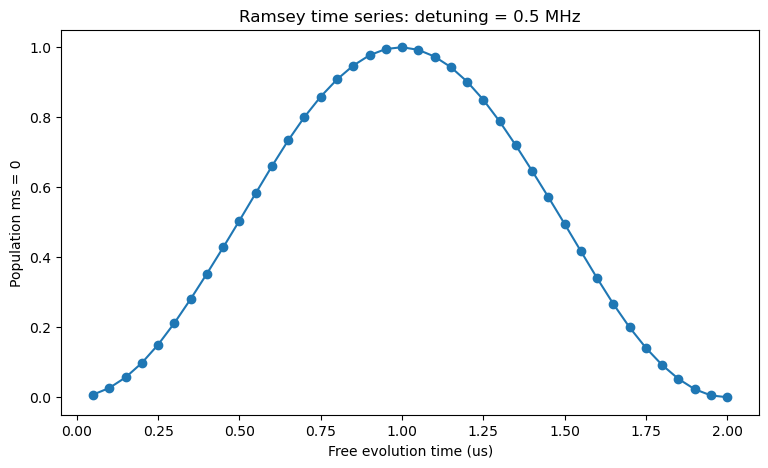

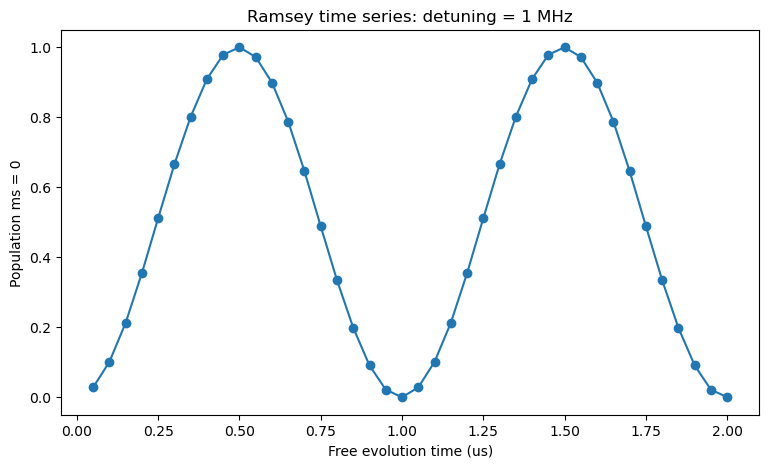

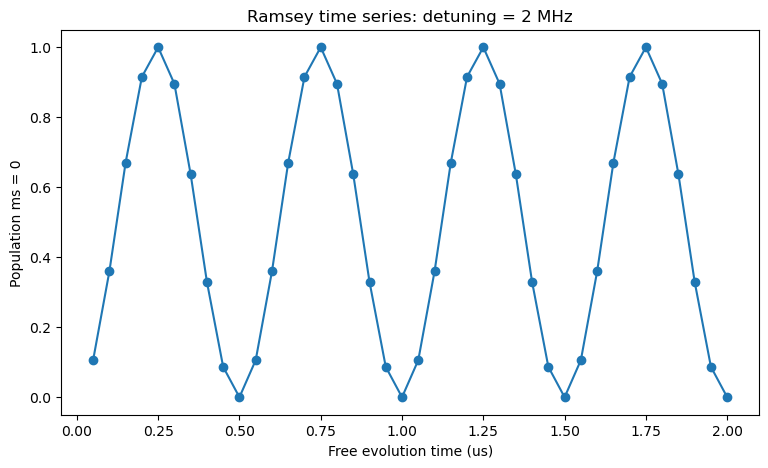

In [26]:
popdata = [[]]*n_detunings
titles = ['Ramsey time series: detuning = 0.5 MHz',
         'Ramsey time series: detuning = 1 MHz',
         'Ramsey time series: detuning = 2 MHz']

for i in np.arange(n_detunings):
    popdata[i] = expect(exp_op, ls_states_timesweep[i])
    f1 = plt.figure(figsize = (9,5))
    ax1 = f1.add_subplot(111)
    ax1.plot(arr_timesfp, popdata[i], '-o')
    ax1.set_title(titles[i])
    ax1.set_xlabel('Free evolution time (us)')
    ax1.set_ylabel('Population ms = 0')
    plt.show()

In [27]:
popdata[2][0::2]

array([0.1061628 , 0.67031253, 0.99972584, 0.63679219, 0.0870632 ,
       0.10621763, 0.67019323, 0.99972153, 0.63683917, 0.08709061,
       0.10627033, 0.67007255, 0.9997172 , 0.6368941 , 0.08711586,
       0.10632   , 0.66995131, 0.99971277, 0.6369546 , 0.08713778])

The frequency of the plot should be equal to the detuning, because in the rotating frame the effective Hamiltonian 

$$ \tilde{H}(t) = (\omega - \omega_0)\hbar S_z = \Delta \hbar S_z $$

causes a precession at a rate equal to the detuning. We can easily see the frequencies in the above plots by eye.

### Change pulse duration

Try different pulse durations corresponding to rotation angles $\frac{\pi}{4}, \frac{\pi}{3}, \frac{\pi}{2}, \frac{3\pi}{2}$ and see how the population oscillations change.

In [28]:
det = 1
frq_rabi = ((BacMHz)**2 + abs(det)**2)**0.5
t_pipulse = 1/frq_rabi/2
#print(t_pipulse) # units us

# try different pulse durations: pi/4, pi/3, pi/2, 3pi/2
t_pulses = [t_pipulse/4, t_pipulse/3, t_pipulse/2, 3*t_pipulse/4]

In [29]:
#
# Array of times for free evolution
# Keep only values greater than duration of pi/4 pulse to avoid overlapping pulses
#
tfp_max = 2 # us
arr_timesfp = np.linspace(0, tfp_max, 41)
arr_timesfp = arr_timesfp[arr_timesfp > t_pulses[3]]
print('arr_timesfp', arr_timesfp, '\n')
print('len(arr_timesfp) =', len(arr_timesfp))

arr_timesfp [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ] 

len(arr_timesfp) = 40


In [30]:
ls_pulsehandlers_Ramsey = []
tlists = []

for i in np.arange(len(t_pulses)):

    # for each time duration of free evolution we generated, run the sequence
    for t_fp in arr_timesfp:
    
        # pulse sequence handler object
        duration_1 = t_pulses[i]
        pulse_handler_Ramsey = Pulse_sequence(Hstat = Hstat)
        tlists.append(np.linspace(-duration_1/2, t_fp+duration_1, 100))

        
        # Loop through two Ramsey pulses
        for tally_p in np.arange(2):
        
            # define pulse timings
            starttime_1 = tally_p*t_fp - duration_1/2
        
            Bamp = B_amp
            frq = frq_trans+det
            phase = 0
            
            # create pulse object and add to pulse sequence handler
            pulse_ramsey_90 = Pulse(ACDpulsetype, start_time = starttime_1, duration = duration_1, coeff_params = {'B_amp': Bamp, 'freq': frq, 'offset': offset, 'phase': phase})
            pulse_handler_Ramsey.add_pulse(pulse_ramsey_90)
                
        # add pulse sequence handlers to list    
        ls_pulsehandlers_Ramsey.append(pulse_handler_Ramsey)

In [31]:
sim_starttime = time.time()


n = len(ls_pulsehandlers_Ramsey)
inputs = zip([state_init]*n, tlists, ls_pulsehandlers_Ramsey)

if __name__ == '__main__':
    with Pool(processes = n) as pool:
        output_map = pool.starmap(exec_pulse_Ramsey, inputs)
        pool.close()
        pool.join()

output_map = list(output_map)

sim_endtime = time.time()
print('Time taken (s)', round(sim_endtime - sim_starttime,3))

Time taken (s) 20.403


In [32]:
n_pulsedurations = len(t_pulses) # number of separate time sweeps, one for each pulse duration
len_timesweep = int(len(output_map)/n_pulsedurations) # length of one time-sweep array's results

ls_states_timesweep = [[]]*n_pulsedurations # create a 2D array to store each of the sweeps' results

for i in np.arange(n_pulsedurations):
    ls_states_timesweep[i] = [elem.states[-1] for elem in output_map[i*len_timesweep:(i+1)*len_timesweep]]

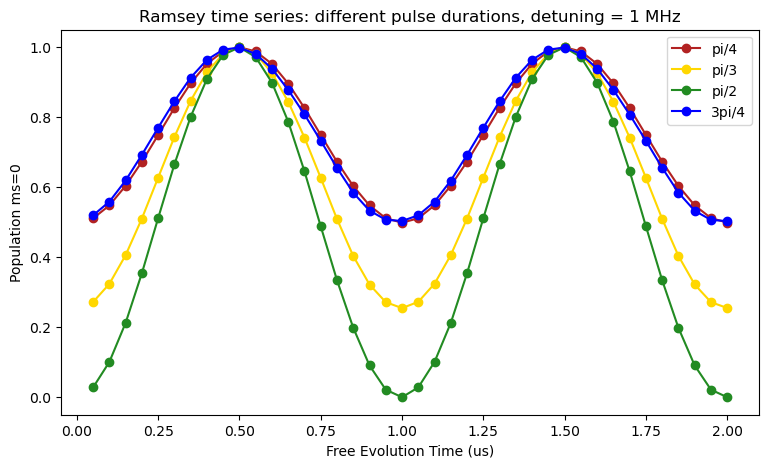

In [33]:
popdata = [[]]*n_pulsedurations
colors = ['firebrick', 'gold', 'forestgreen', 'blue']

plt.figure(figsize=(9,5))
for i in np.arange(n_pulsedurations):
    popdata[i] = expect(exp_op, ls_states_timesweep[i])
    plt.plot(arr_timesfp, popdata[i], '-o', color = colors[i])

plt.xlabel('Free Evolution Time (us)')
plt.ylabel('Population ms=0')
plt.legend(['pi/4', 'pi/3', 'pi/2', '3pi/4'])
plt.title('Ramsey time series: different pulse durations, detuning = 1 MHz')
plt.show()

It makes sense that pulses that aren't the $\pi/2$ pulse will yield a smaller amplitude; for example, the $\pi/4$ pulse will only take the initial spin ms = 0 to a $45^{\circ}$ angle from the vertical instead of bringing it horizontal on the Bloch sphere. During free evolution, the spin will then precess on that $45^{\circ}$ cone. Since the second pulse is also $\pi/4$ in this case, the lowest that the spin can "reach" at the end of the sequence is $90^{\circ}$ from the vertical. Since this angle corresponds to a transverse spin on the Bloch sphere, the final probability of measuring ms = 0 will be 50%. 

In the $\pi/2$ pulse case, the spin can reach 0% probability of being measured as ms = 0 when the optimal free evolution duration is chosen. 

### Magnetometry context

The Ramsey pulse sequence can be used in magnetometry. Looking at the time-sweep curve, we choose a free evolution time that gives us a large rate of change in the population. Then, keeping the free evolution time constant and using standard $\pi/2$ pulses, we sweep the detuning around a chosen value. Since the time sweep population curve is of the form

$$ P = A\cos(2\pi~\Delta~\tau+\phi)+k $$

If we make $\tau = t_{fp} $ constant and vary $\Delta$ we will still get an oscillation $P(\Delta)$ of the same form. The result will then be a cosine curve with frequency $t_{fp} $. 

In [34]:
# pick initial detuning of 1 MHz and tau 1 us

#try sweeping detuning from 0 to 2

tfp = 1 # us

arr_detunings = np.linspace(0.1, 2, 41)

In [35]:
ls_pulsehandlers_Ramsey = []
tlists = []


# for each time duration of free evolution we generated, run the sequence
for det in arr_detunings:
    
    # define pulse timings
    frq_rabi = ((BacMHz)**2 + abs(det)**2)**0.5
    t_pipulse = 1/frq_rabi/2
    duration_1 = t_pipulse/2
    
    # pulse sequence handler object
    pulse_handler_Ramsey = Pulse_sequence(Hstat = Hstat)
    tlists.append(np.linspace(-duration_1/2, tfp+duration_1, 100))

        
    # Loop through two Ramsey pulses
    for tally_p in np.arange(2):
        
        starttime_1 = tally_p*tfp - duration_1/2
        
        Bamp = B_amp
        frq = frq_trans+det
        phase = 0
        offset = 0
            
        # create pulse object and add to pulse sequence handler
        pulse_ramsey_90 = Pulse(ACDpulsetype, start_time = starttime_1, duration = duration_1, coeff_params = {'B_amp': Bamp, 'freq': frq, 'offset': offset, 'phase': phase})
        pulse_handler_Ramsey.add_pulse(pulse_ramsey_90)
                
    # add pulse sequence handlers to list    
    ls_pulsehandlers_Ramsey.append(pulse_handler_Ramsey)

In [36]:
sim_starttime = time.time()


n = len(ls_pulsehandlers_Ramsey)
inputs = zip([state_init]*n, tlists, ls_pulsehandlers_Ramsey)

if __name__ == '__main__':
    with Pool(processes = n) as pool:
        output_map = pool.starmap(exec_pulse_Ramsey, inputs)
        pool.close()
        pool.join()

output_map = list(output_map)

sim_endtime = time.time()
print('Time taken (s)', round(sim_endtime - sim_starttime,3))

Time taken (s) 5.161


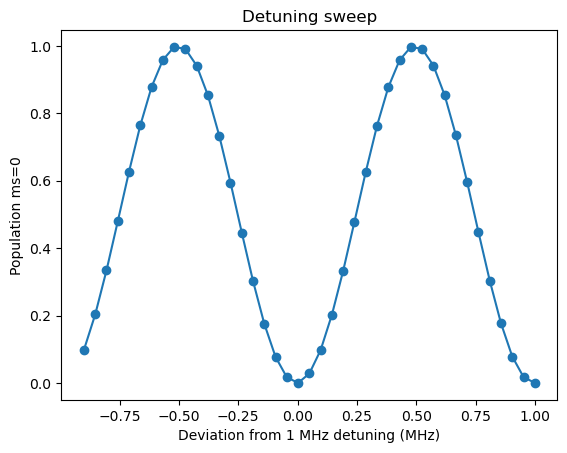

In [37]:
ls_states = [elem.states[-1] for elem in output_map]
arr_det_difference = [detuning-1 for detuning in arr_detunings]
popdata = expect(exp_op, ls_states)
plt.plot(arr_det_difference, popdata, '-o')

plt.xlabel('Deviation from 1 MHz detuning (MHz)')
plt.ylabel('Population ms=0')
plt.title('Detuning sweep')
plt.show()

In the above plot, we see that the frequency is exactly $t_{fp} = 1 $ MHz as we expected.

The detuning is related to the strength of the applied magnetic field of the rotating frame via 

$$ \Delta = -\gamma B $$

so we can make a new curve of population vs. B-field with this change. Then, the functional form of the new curve will be 

$$ P = A\cos(2\pi\gamma t_{fp} B )+k $$

and the frequency will be $ \gamma t_{fp} $ if B-field strength is the independent variable.

In magnetometry, this plot acts as a "reference plot;" it tells us how the ms = 0 population ratio relates to the strength of the applied field. We can then introduce the sample whose B-field we are interested in measuring, and observe the fluorescence of the NV center that tells us the population of the ms = 0 state. Then, we can just read off the B-field strength from the horizontal axis. 

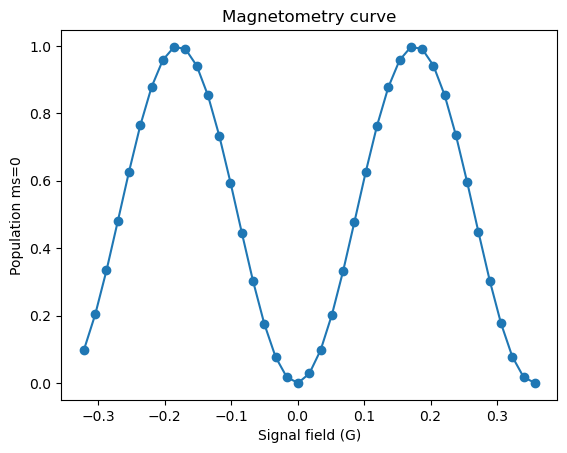

In [38]:
arr_B = [-(detuning-1)/gammaNV for detuning in arr_detunings]
plt.plot(arr_B, popdata, '-o')

plt.xlabel('Signal field (G)')
plt.ylabel('Population ms=0')
plt.title('Magnetometry curve')
plt.show()

### Find frequency of magnetometry plot using curve fit

In [39]:
# find frequency using a curve fit

def func(t, A, frequency, phase, k):
    return A*np.cos(2*np.pi*frequency*t+phase)+k

In [40]:
popt, pcov = curve_fit(func, [-detuning/gammaNV for detuning in arr_detunings], popdata, p0 = [0.5, 1/0.4, np.pi, 0.5])
print('A ', popt[0])
print('Frequency = ', popt[1])
print('phase ', popt[2])
print('k ', popt[3])

A  0.4992852240148528
Frequency =  2.808673428227692
phase  3.1459433938888086
k  0.4999827736444259


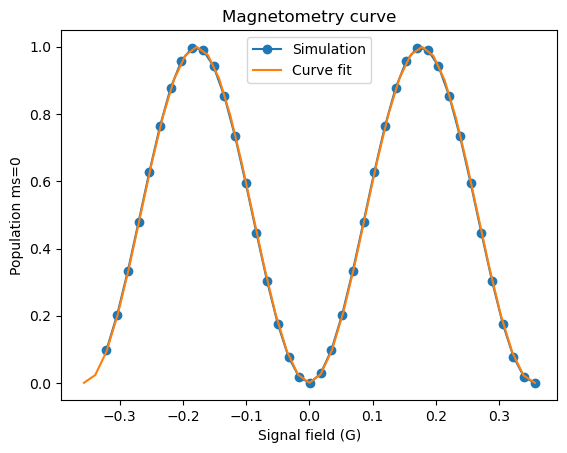

In [41]:
plt.plot(arr_B, popdata, '-o')
plt.plot(np.linspace(-1/gammaNV, 1/gammaNV, 41), func(np.linspace(-1/gammaNV, 1/gammaNV, 41), popt[0], popt[1], popt[2], popt[3]))
plt.xlabel('Signal field (G)')
plt.ylabel('Population ms=0')
plt.title('Magnetometry curve')
plt.legend(['Simulation', 'Curve fit'])
plt.show()

In [42]:
print(-gammaNV*tfp)

2.8025


Above, we see that the frequency of the plot is $\gamma t_{fp} $ as we expected.

In this tutorial, we examined the Ramsey pulse sequence. We compared theoretical and simulated results when the free-evolution time, detuning, and pulse duration were varied. We also applied the Ramsey pulse sequence to the magnetometry context, looking at how the sequence is used to measure applied magnetic fields. 